In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/commonlitreadabilityprize/sample_submission.csv
/kaggle/input/commonlitreadabilityprize/train.csv
/kaggle/input/commonlitreadabilityprize/test.csv


# CommonLit Readability Prize

Competition URL: https://www.kaggle.com/c/commonlitreadabilityprize/overview

**code credits** \
model training: https://www.kaggle.com/maunish/clrp-pytorch-roberta-finetune \
pooling method: https://www.kaggle.com/rhtsingh/utilizing-transformer-representations-efficiently \
feature build: https://www.kaggle.com/maximkazantsev/commonlit-readability-univ-sent-encoder-xgb \
model saving for future use: https://www.kaggle.com/questions-and-answers/92749 \
other: https://www.kaggle.com/vineethakkinapalli/clrp-roberta-base-representation-techniques

In this notebook I try to combine features extracted from excerpt into the model training process. There are 3 basic model I used, RoBertA with last 4 layers representations, RoBertA with a attention head, and Attention Pooling method on RoBertA.
The submission answer is the average value of all 15 models (each model has five submodels).

In [5]:
!pip3 install accelerate

     |████████████████████████████████| 49 kB 256 kB/s eta 0:00:01


In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk import pos_tag
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize, sent_tokenize
import numpy as np
import re
import seaborn as sns
from transformers import AutoModel,AutoConfig,AutoTokenizer,get_cosine_schedule_with_warmup
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from accelerate import Accelerator
import random
import os
import numpy as np
import torch
import torch.optim as optim
from sklearn.model_selection import StratifiedKFold
import joblib

from colorama import Fore, Back, Style
r_ = Fore.RED
b_ = Fore.BLUE
c_ = Fore.CYAN
g_ = Fore.GREEN
y_ = Fore.YELLOW
m_ = Fore.MAGENTA
sr_ = Style.RESET_ALL

In [7]:
train = pd.read_csv("/kaggle/input/commonlitreadabilityprize/train.csv")
test = pd.read_csv("/kaggle/input/commonlitreadabilityprize/test.csv")
sample = pd.read_csv("/kaggle/input/commonlitreadabilityprize/sample_submission.csv")

In [8]:
train.head()

,id,url_legal,license,excerpt,target,standard_error
0,c12129c31,NaN,NaN,When the young people returned to the ballroom...,-0.340259,0.464009
1,85aa80a4c,NaN,NaN,"All through dinner time, Mrs. Fayre was somewh...",-0.315372,0.480805
2,b69ac6792,NaN,NaN,"As Roger had predicted, the snow departed as q...",-0.580118,0.476676
3,dd1000b26,NaN,NaN,And outside before the palace a great garden w...,-1.054013,0.450007
4,37c1b32fb,NaN,NaN,Once upon a time there were Three Bears who li...,0.247197,0.510845


In [9]:
train.shape

(2834, 6)

In [10]:
test.head()

,id,url_legal,license,excerpt
0,c0f722661,NaN,NaN,My hope lay in Jack's promise that he would ke...
1,f0953f0a5,NaN,NaN,Dotty continued to go to Mrs. Gray's every nig...
2,0df072751,NaN,NaN,It was a bright and cheerful scene that greete...
3,04caf4e0c,https://en.wikipedia.org/wiki/Cell_division,CC BY-SA 3.0,Cell division is the process by which a parent...
4,0e63f8bea,https://en.wikipedia.org/wiki/Debugging,CC BY-SA 3.0,Debugging is the process of finding and resolv...


In [11]:
test.shape

(7, 4)

In [12]:
train.target.describe()

count    2834.000000
mean       -0.959319
std         1.033579
min        -3.676268
25%        -1.690320
50%        -0.912190
75%        -0.202540
max         1.711390
Name: target, dtype: float64

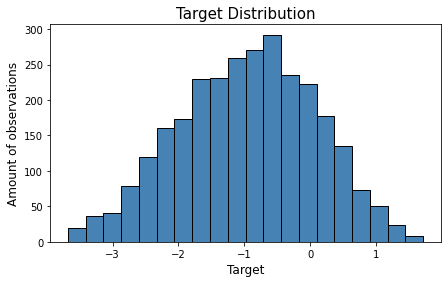

In [13]:
fig, ax = plt.subplots(figsize=(7, 4))
ax.hist(train["target"], bins=20, edgecolor="black", color="steelblue")
ax.set_title("Target Distribution", fontsize=15)
ax.set_xlabel("Target", fontsize=12)
ax.set_ylabel("Amount of observations", fontsize=12)
plt.show();

In [15]:
#train data excerpt length
train["len"] = train.excerpt.apply(len)
test["len"] = test.excerpt.apply(len)

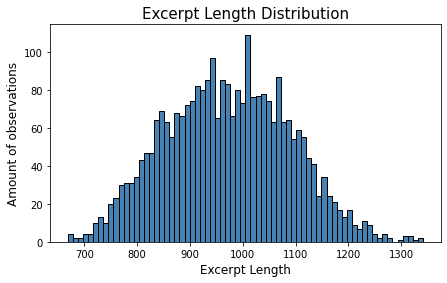

In [16]:
fig, ax = plt.subplots(figsize=(7, 4))
ax.hist(train.len, bins=70, edgecolor="black", color="steelblue")
ax.set_title("Excerpt Length Distribution", fontsize=15)
ax.set_xlabel("Excerpt Length", fontsize=12)
ax.set_ylabel("Amount of observations", fontsize=12)
plt.show();

In [17]:
train["excerpt"] = train.excerpt.apply(lambda x: x.replace("\n"," "))
test["excerpt"] = test.excerpt.apply(lambda x: x.replace("\n"," "))

In [18]:
def feature(excerpt, stop_words):
    dialogue_counts=excerpt.count('"')/2
    num_sentence = len(sent_tokenize(excerpt))
    
    words = word_tokenize(re.sub("[^a-zA-Z]", " ", excerpt).lower())
    initial_num_words = len(words)
    target_words = [word for word in words if word not in stop_words]
    processed_num_words=len(target_words)
    text_shrinkage = processed_num_words/initial_num_words
    avg_sentence_length = initial_num_words / num_sentence
    
    return dialogue_counts, num_sentence, processed_num_words, text_shrinkage, avg_sentence_length

In [19]:
stop_words = set(stopwords.words("english"))
train['feature'] = train.excerpt.apply(feature, stop_words= stop_words)
test['feature'] = test.excerpt.apply(feature, stop_words= stop_words)
train["dialogue"], train["num_sentence"], train["num_processed_words"], train['text_shrinkage'], \
train["avg_sentence_length"] = zip(*train.feature)

test["dialogue"], test["num_sentence"], test["num_processed_words"], test['text_shrinkage'], \
test["avg_sentence_length"] = zip(*test.feature)

In [20]:
train.drop(columns="feature", inplace=True)
test.drop(columns="feature", inplace=True)

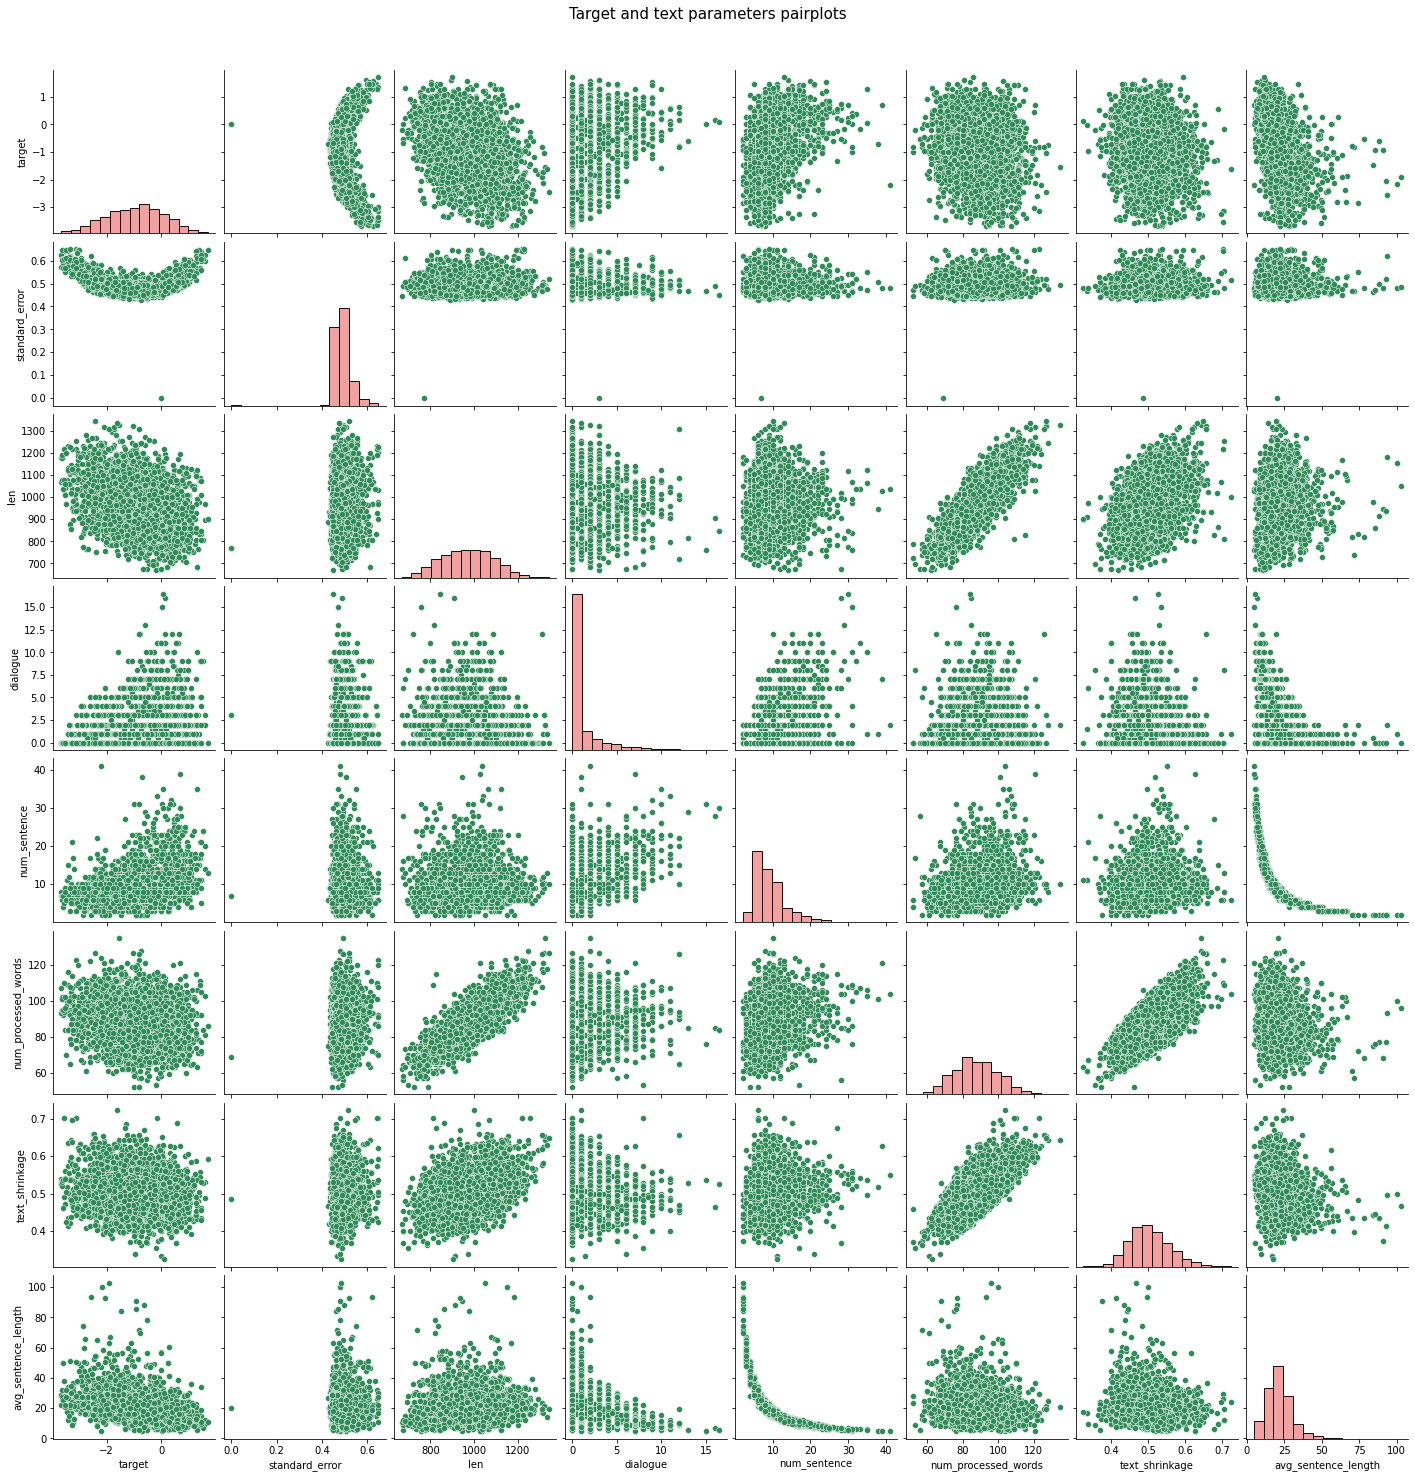

<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x7f4f0dfa7390>>

In [21]:
ax = sns.pairplot(data=train,
                  diag_kws=dict(bins=15, color="lightcoral"),
                  plot_kws=dict(color="seagreen"))
ax.fig.suptitle("Target and text parameters pairplots", fontsize=15, y=1.03)
plt.show();input

In [22]:
class CLRPDataset(Dataset):
    def __init__(self,df,tokenizer,feature,max_len=256, train=True):
        self.excerpt = df['excerpt'].to_numpy()
        self.train = train
        if self.train:
            self.targets = df['target'].to_numpy()
        self.feature = feature
        self.max_len = max_len
        self.tokenizer = tokenizer
    
    def __getitem__(self,idx):
        encode = self.tokenizer(self.excerpt[idx],
                                return_tensors='pt',
                                max_length=self.max_len,
                                padding='max_length',
                                truncation=True)
        
        feature = torch.tensor(self.feature[idx],dtype=torch.float,)
        
        if self.train:
            target = torch.tensor(self.targets[idx],dtype=torch.float) 
            return encode, feature, target
        else:
            return encode, feature
    
    def __len__(self):
        return len(self.excerpt)

In [23]:
config = {
    'lr': 2e-5,
    'wd':0.01,
    'batch_size':16,
    'valid_step':10,
    'max_len':500,
    'epochs':5,
    'nfolds':5,
    'seed':9527,
    'model_path':'roberta-base',
}

def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONASSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
seed_everything(seed=config['seed'])

In [24]:
for i in range(config['nfolds']):
    os.makedirs(f'concat_model{i}',exist_ok=True)
for i in range(config['nfolds']):
    os.makedirs(f'atHead_model{i}',exist_ok=True)
for i in range(config['nfolds']):
    os.makedirs(f'atPool_model{i}',exist_ok=True)
os.makedirs('scaler',exist_ok=True)

In [25]:
num_bins = int(np.floor(1 + np.log2(len(train))))
train.loc[:,'bins'] = pd.cut(train['target'],bins=num_bins,labels=False)
bins = train.bins.to_numpy()

train['Fold'] = -1
kfold = StratifiedKFold(n_splits=config['nfolds'],shuffle=True,random_state=config['seed'])
for k , (train_idx,valid_idx) in enumerate(kfold.split(X=train, y=bins)):
    train.loc[valid_idx,'Fold'] = k

In [26]:
class Model(nn.Module):
    def __init__(self,path):
        super(Model,self).__init__()
        self.config = AutoConfig.from_pretrained(path)
        self.config.update({'output_hidden_states':True,"hidden_dropout_prob": 0.0})
        self.roberta = AutoModel.from_pretrained(path,config=self.config)
        self.linear = nn.Linear(self.config.hidden_size*4+5, 1, 1)

    def forward(self,feature, **xb):
        x = self.roberta(**xb)
        x = torch.stack(x[2])
        x = torch.cat((x[-1], x[-2], x[-3], x[-4]),-1)
        x = x[:, 0]
        x = torch.cat((x,feature), -1)
        x = self.linear(x)
        return x

In [27]:
class AttentionHead(nn.Module):
    def __init__(self, in_features, hidden_dim):
        super(AttentionHead, self).__init__()
        self.in_features = in_features
        self.middle_features = hidden_dim
        self.W = nn.Linear(in_features, hidden_dim)
        self.V = nn.Linear(hidden_dim, 1)
        self.out_features = hidden_dim

    def forward(self, features):
        att = torch.tanh(self.W(features))
        score = self.V(att)
        attention_weights = torch.softmax(score, dim=1)
        context_vector = attention_weights * features
        context_vector = torch.sum(context_vector, dim=1)

        return context_vector
    
class ATHeadModel(nn.Module):
    def __init__(self,path):
        super(ATHeadModel,self).__init__()
        self.roberta = AutoModel.from_pretrained(path)  
        self.config = AutoConfig.from_pretrained(path)
        self.head = AttentionHead(self.config.hidden_size,self.config.hidden_size)
        self.dropout = nn.Dropout(0.1)
        self.linear = nn.Linear(self.config.hidden_size+5,1)

    def forward(self,feature,**xb):
        x = self.roberta(**xb)[0]
        x = self.head(x)
        x = self.dropout(x)
        x = torch.cat((x,feature), -1)
        x = self.linear(x)
        return x

In [28]:
class AttentionPoolingModel(nn.Module):
    def __init__(self, path):
        super(AttentionPoolingModel, self).__init__() 
        self.config = AutoConfig.from_pretrained(path)
        self.config.update({'output_hidden_states':True,"hidden_dropout_prob": 0.0})
        self.roberta = AutoModel.from_pretrained(path,config=self.config)
        self.dropout = nn.Dropout(0.1)
        self.linear = nn.Linear(self.config.hidden_size+5,1)

        q_t = np.random.normal(loc=0.0, scale=0.1, size=(1, self.config.hidden_size))
        self.q = nn.Parameter(torch.from_numpy(q_t).float())
        w_ht = np.random.normal(loc=0.0, scale=0.1, size=(self.config.hidden_size, self.config.hidden_size))
        self.w_h = nn.Parameter(torch.from_numpy(w_ht).float())

    def forward(self, feature, **xb):
        x = self.roberta(**xb)
        x = torch.stack(x[2])
        x = torch.stack([x[layer_i][:, 0].squeeze() for layer_i in range(1, self.config.num_hidden_layers+1)], dim=-1)
        x = x.view(-1, self.config.num_hidden_layers, self.config.hidden_size)
        x = self.attention(x)
        x = self.dropout(x)
        x = torch.cat((x,feature), -1)
        x = self.linear(x)
        return x

    def attention(self, h):
        v = torch.matmul(self.q, h.transpose(-2, -1)).squeeze(1)
        v = F.softmax(v, -1)
        v_temp = torch.matmul(v.unsqueeze(1), h).transpose(-2, -1)
        v = torch.matmul(self.w_h.transpose(1, 0), v_temp).squeeze(2)
        return v

In [29]:
def run(fold, MODEL, verbose=True):
    
    
    model_dict = {"concat_model":Model,
                  "atHead_model":ATHeadModel,
                  "atPool_model":AttentionPoolingModel}
    
    def loss_fn(outputs,targets):
        outputs = outputs.view(-1)
        targets = targets.view(-1)
        return torch.sqrt(nn.MSELoss()(outputs,targets))
    
    def train_and_evaluate_loop(train_loader,valid_loader,model,loss_fn,optimizer,epoch,fold,best_loss,valid_step=10,lr_scheduler=None):
        train_loss = 0
        for i, (inputs1,feature1,targets1) in enumerate(train_loader):
            model.train()
            optimizer.zero_grad()
            inputs1 = {key:val.reshape(val.shape[0],-1) for key,val in inputs1.items()}
            outputs1 = model(feature1, **inputs1)
            loss1 = loss_fn(outputs1,targets1)
            loss1.backward()
            optimizer.step()
            
            train_loss += loss1.item()
            
            if lr_scheduler:
                lr_scheduler.step()
            
            #evaluating for every valid_step
            #if (i % valid_step == 0) or ((i + 1) == len(train_loader)):
            if (i + 1) == len(train_loader):
                model.eval()
                valid_loss = 0
                with torch.no_grad():
                    for j, (inputs2,feature2,targets2) in enumerate(valid_loader):
                        inputs2 = {key:val.reshape(val.shape[0],-1) for key,val in inputs2.items()}
                        outputs2 = model(feature2,**inputs2)
                        loss2 = loss_fn(outputs2,targets2)
                        valid_loss += loss2.item()
                     
                    valid_loss /= len(valid_loader)
                    if valid_loss <= best_loss:
                        if verbose:
                            print(f"epoch:{epoch} | Train Loss:{train_loss/(i+1)} | Validation loss:{valid_loss}")
                            print(f"{g_}Validation loss Decreased from {best_loss} to {valid_loss}{sr_}")

                        best_loss = valid_loss
                        torch.save(model.state_dict(),f'./{MODEL}{fold}/model.bin')
                        tokenizer.save_pretrained(f'./{MODEL}{fold}')
                        
        return best_loss
    
    accelerator = Accelerator()
    print(f"{accelerator.device} is used")
    
    x_train,x_valid = train.query(f"Fold != {fold}"),train.query(f"Fold == {fold}")
    
    if os.path.isfile(f"scaler/scaler_fold{fold}.gz"):
        scaler = joblib.load(f"scaler/scaler_fold{fold}.gz") 
    else:
        scaler = StandardScaler()
        scaler.fit(x_train.iloc[:,9:].to_numpy())
        joblib.dump(scaler, f"scaler/scaler_fold{fold}.gz")
    x_train_feature=scaler.transform(x_train.iloc[:,9:].to_numpy())
    x_valid_feature=scaler.transform(x_valid.iloc[:,9:].to_numpy())
    
    
    tokenizer = AutoTokenizer.from_pretrained(config['model_path'])
    model = model_dict[MODEL](config['model_path'])

    train_ds = CLRPDataset(x_train,tokenizer,x_train_feature,config['max_len'])
    train_dl = DataLoader(train_ds,
                        batch_size = config["batch_size"],
                        shuffle=True,
                        num_workers = 4,
                        pin_memory=True,
                        drop_last=False)

    valid_ds = CLRPDataset(x_valid,tokenizer,x_valid_feature,config['max_len'])
    valid_dl = DataLoader(valid_ds,
                        batch_size = config["batch_size"],
                        shuffle=False,
                        num_workers = 4,
                        pin_memory=True,
                        drop_last=False)

    optimizer = optim.AdamW(model.parameters(),lr=config['lr'],weight_decay=config['wd'])
    lr_scheduler = get_cosine_schedule_with_warmup(optimizer,num_warmup_steps=0,num_training_steps= 10 * len(train_dl))

    model,train_dl,valid_dl,optimizer,lr_scheduler = accelerator.prepare(model,train_dl,valid_dl,optimizer,lr_scheduler)

    print(f"Fold: {fold}")
    best_loss = 9999
    for epoch in range(config["epochs"]):
        print(f"Epoch Started:{epoch}")
        best_loss = train_and_evaluate_loop(train_dl,valid_dl,model,loss_fn,
                                            optimizer,epoch,fold,best_loss,
                                            valid_step=config['valid_step'],lr_scheduler=lr_scheduler)

In [30]:
def get_prediction(df,Fold,MODEL,path,model_path,device='cuda'):
    outputs = np.zeros(len(df))
    for f in range(Fold):
        accelerator = Accelerator()
        model = MODEL(model_path)
        model.load_state_dict(torch.load(path+f"{f}/model.bin",map_location=device))
        model.eval()
        

        tokenizer = AutoTokenizer.from_pretrained(model_path)
        
        scaler = joblib.load(f"scaler/scaler_fold{f}.gz")
        df_feature = scaler.transform(df.iloc[:,5:].to_numpy())

        test_ds = CLRPDataset(df,tokenizer,df_feature, config['max_len'],train=False)
        test_dl = DataLoader(test_ds,
                            batch_size = config["batch_size"],
                            shuffle=False,
                            num_workers = 4,
                            pin_memory=True)
        
        model,test_dl = accelerator.prepare(model,test_dl)

        predictions = list()
        for i, (inputs, feature) in enumerate(test_dl):
            inputs = {key:val.reshape(val.shape[0],-1) for key,val in inputs.items()}
            outputs = model(feature, **inputs)
            outputs = outputs.cpu().detach().numpy().ravel().tolist()
            predictions.extend(outputs)

        torch.cuda.empty_cache()
        outputs+=np.array(predictions)
    return outputs/Fold

In [44]:
for f in range(config['nfolds']):
    run(f, 'concat_model')

cuda is used


Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/501M [00:00<?, ?B/s]

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Fold: 0
Epoch Started:0
epoch:0 | Train Loss:0.6861157102484099 | Validation loss:0.5458745484550794
Validation loss Decreased from 9999 to 0.5458745484550794
Epoch Started:1
epoch:1 | Train Loss:0.4556661145368093 | Validation loss:0.5264163936177889
Validation loss Decreased from 0.5458745484550794 to 0.5264163936177889
Epoch Started:2
epoch:2 | Train Loss:0.33715694544600766 | Validation loss:0.4989985591835446
Validation loss Decreased from 0.5264163936177889 to 0.4989985591835446
Epoch Started:3
epoch:3 | Train Loss:0.2361377477645874 | Validation loss:0.4910426595144802
Validation loss Decreased from 0.4989985591835446 to 0.4910426595144802
Epoch Started:4
cuda is used


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Fold: 1
Epoch Started:0
epoch:0 | Train Loss:0.6750002757344448 | Validation loss:0.49220481763283414
Validation loss Decreased from 9999 to 0.49220481763283414
Epoch Started:1
epoch:1 | Train Loss:0.4402375724953665 | Validation loss:0.4789656044708358
Validation loss Decreased from 0.49220481763283414 to 0.4789656044708358
Epoch Started:2
Epoch Started:3
Epoch Started:4
cuda is used


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Fold: 2
Epoch Started:0
epoch:0 | Train Loss:0.7102370883377505 | Validation loss:0.5416221668322881
Validation loss Decreased from 9999 to 0.5416221668322881
Epoch Started:1
epoch:1 | Train Loss:0.45342342471572716 | Validation loss:0.5234515708353784
Validation loss Decreased from 0.5416221668322881 to 0.5234515708353784
Epoch Started:2
Epoch Started:3
epoch:3 | Train Loss:0.24119354165355925 | Validation loss:0.4954050588938925
Validation loss Decreased from 0.5234515708353784 to 0.4954050588938925
Epoch Started:4
cuda is used


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Fold: 3
Epoch Started:0
epoch:0 | Train Loss:0.6913400176965016 | Validation loss:0.5577885260184606
Validation loss Decreased from 9999 to 0.5577885260184606
Epoch Started:1
epoch:1 | Train Loss:0.4557472220818761 | Validation loss:0.4940917359458076
Validation loss Decreased from 0.5577885260184606 to 0.4940917359458076
Epoch Started:2
epoch:2 | Train Loss:0.3347090862586465 | Validation loss:0.4896436515781615
Validation loss Decreased from 0.4940917359458076 to 0.4896436515781615
Epoch Started:3
Epoch Started:4
cuda is used


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Fold: 4
Epoch Started:0
epoch:0 | Train Loss:0.6761799507157903 | Validation loss:0.5181149947974417
Validation loss Decreased from 9999 to 0.5181149947974417
Epoch Started:1
epoch:1 | Train Loss:0.4485845844930326 | Validation loss:0.5027141943573952
Validation loss Decreased from 0.5181149947974417 to 0.5027141943573952
Epoch Started:2
Epoch Started:3
Epoch Started:4
epoch:4 | Train Loss:0.17348470801198987 | Validation loss:0.490186161465115
Validation loss Decreased from 0.5027141943573952 to 0.490186161465115


In [45]:
for f in range(config['nfolds']):
    run(f, 'atHead_model')

cuda is used


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Fold: 0
Epoch Started:0
epoch:0 | Train Loss:0.6973800142885933 | Validation loss:0.7343639019462798
Validation loss Decreased from 9999 to 0.7343639019462798
Epoch Started:1
epoch:1 | Train Loss:0.49173955640322725 | Validation loss:0.574103783402178
Validation loss Decreased from 0.7343639019462798 to 0.574103783402178
Epoch Started:2
epoch:2 | Train Loss:0.39376729370003016 | Validation loss:0.5563371694750257
Validation loss Decreased from 0.574103783402178 to 0.5563371694750257
Epoch Started:3
Epoch Started:4
cuda is used


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Fold: 1
Epoch Started:0
epoch:0 | Train Loss:0.6674697308892935 | Validation loss:0.5999312400817871
Validation loss Decreased from 9999 to 0.5999312400817871
Epoch Started:1
Epoch Started:2
Epoch Started:3
Epoch Started:4
cuda is used


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Fold: 2
Epoch Started:0
epoch:0 | Train Loss:0.7207102721006098 | Validation loss:0.619796958234575
Validation loss Decreased from 9999 to 0.619796958234575
Epoch Started:1
Epoch Started:2
Epoch Started:3
Epoch Started:4
epoch:4 | Train Loss:0.23787479281005725 | Validation loss:0.6158663771218724
Validation loss Decreased from 0.619796958234575 to 0.6158663771218724
cuda is used


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Fold: 3
Epoch Started:0
epoch:0 | Train Loss:0.656798929815561 | Validation loss:0.5163498702976439
Validation loss Decreased from 9999 to 0.5163498702976439
Epoch Started:1
Epoch Started:2
Epoch Started:3
Epoch Started:4
cuda is used


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Fold: 4
Epoch Started:0
epoch:0 | Train Loss:0.6994148694293599 | Validation loss:0.6304177327288522
Validation loss Decreased from 9999 to 0.6304177327288522
Epoch Started:1
epoch:1 | Train Loss:0.5020130014335605 | Validation loss:0.5944087248709466
Validation loss Decreased from 0.6304177327288522 to 0.5944087248709466
Epoch Started:2
Epoch Started:3
Epoch Started:4


In [46]:
for f in range(config['nfolds']):
    run(f, 'atPool_model')

cuda is used


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Fold: 0
Epoch Started:0
epoch:0 | Train Loss:0.8290717001532165 | Validation loss:0.5272958543565538
Validation loss Decreased from 9999 to 0.5272958543565538
Epoch Started:1
Epoch Started:2
epoch:2 | Train Loss:0.374560207023587 | Validation loss:0.4852817588382297
Validation loss Decreased from 0.5272958543565538 to 0.4852817588382297
Epoch Started:3
Epoch Started:4
cuda is used


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Fold: 1
Epoch Started:0
epoch:0 | Train Loss:0.7566094037512658 | Validation loss:0.5860530560215315
Validation loss Decreased from 9999 to 0.5860530560215315
Epoch Started:1
epoch:1 | Train Loss:0.49173664228177405 | Validation loss:0.5037283210290803
Validation loss Decreased from 0.5860530560215315 to 0.5037283210290803
Epoch Started:2
Epoch Started:3
Epoch Started:4
cuda is used


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Fold: 2
Epoch Started:0
epoch:0 | Train Loss:0.7263991494833584 | Validation loss:0.595731278260549
Validation loss Decreased from 9999 to 0.595731278260549
Epoch Started:1
epoch:1 | Train Loss:0.47576680863407295 | Validation loss:0.48107679188251495
Validation loss Decreased from 0.595731278260549 to 0.48107679188251495
Epoch Started:2
epoch:2 | Train Loss:0.35355096069020286 | Validation loss:0.4803529249297248
Validation loss Decreased from 0.48107679188251495 to 0.4803529249297248
Epoch Started:3
Epoch Started:4
epoch:4 | Train Loss:0.19051121196276705 | Validation loss:0.4771685277422269
Validation loss Decreased from 0.4803529249297248 to 0.4771685277422269
cuda is used


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Fold: 3
Epoch Started:0
epoch:0 | Train Loss:0.7194956526370115 | Validation loss:0.5125207992063628
Validation loss Decreased from 9999 to 0.5125207992063628
Epoch Started:1
epoch:1 | Train Loss:0.4757941413513372 | Validation loss:0.4770980609787835
Validation loss Decreased from 0.5125207992063628 to 0.4770980609787835
Epoch Started:2
Epoch Started:3
Epoch Started:4
cuda is used


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Fold: 4
Epoch Started:0
epoch:0 | Train Loss:0.6893076472718951 | Validation loss:0.5565681656201681
Validation loss Decreased from 9999 to 0.5565681656201681
Epoch Started:1
Epoch Started:2
epoch:2 | Train Loss:0.34059596208619397 | Validation loss:0.4992472007870674
Validation loss Decreased from 0.5565681656201681 to 0.4992472007870674
Epoch Started:3
epoch:3 | Train Loss:0.2737927679234827 | Validation loss:0.49719443710313904
Validation loss Decreased from 0.4992472007870674 to 0.49719443710313904
Epoch Started:4
epoch:4 | Train Loss:0.18117701361926508 | Validation loss:0.48322487870852154
Validation loss Decreased from 0.49719443710313904 to 0.48322487870852154


In [47]:
answer1=get_prediction(test,config["nfolds"],Model,"concat_model",config['model_path'],device='cuda')
answer2=get_prediction(test,config["nfolds"],ATHeadModel,"atHead_model",config['model_path'],device='cuda')
answer3=get_prediction(test,config["nfolds"],AttentionPoolingModel,"atPool_model",config['model_path'],device='cuda')

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaMod

In [48]:
answer=(answer1+answer2+answer3)/3
sample['target']=answer
sample.to_csv('submission.csv',index=False)